In [1]:
# General libraries
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import os

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.collections as clt
import seaborn as sns
sns.set(style="whitegrid",font_scale=2)
sns.set(style="whitegrid",font_scale=2)
import ptitprince as pt
%matplotlib inline

# Statistical analysis
import scipy.stats as stats
import scikit_posthocs as sp

# Chemical Data Processing
from rdkit.Chem import PandasTools 
PandasTools.RenderImagesInAllDataFrames(images=True)

Remember, that we just included the (most) fully resolved ligand copies!

In [2]:
info_cols = ['Ligand_Instance', 'PDB_ID', 'Standardized_SMILES',  'Pocket', 'ATP_Site', 'Peripheral']

desc_cols_1 = ['MW', 'HBA', 'HBD', 'LogP', 'NRB', 'TPSA', 'Rings', 'NAR', 'NP-Likeness', 'Num_Heavy_Atoms',]  
desc_cols_2 = ['Fsp3', 'FCStereo', 'SPS', 'nSPS', 'PBF', 'nPBF', 'PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2', 'ΣNPR']

threshold_desc_cols = ['Fsp3_0.42', 'ΣNPR_1.07']

# Function to create paths and read in different descriptor (sub)sets

def prepare_descriptor_data(insilico      = False, protbound       = False, 
                            ATP_site_only = False, peripheral_only = False, 
                            Ro5_Filtering = False, Ro3_Filtering   = False,): 
    
    """
    Read in the descriptor values from the file path constructed. 
    Descriptors were either computed from the in silico generated OR protein bound ligand conformations. 
    Optional Filtering for ATP-site ligands OR peripheral ligands only.
    Optional Filtering for Ro5- or Ro3-compliant ligands only.

    The descriptor data are are averaged across conformations (mean ± standard deviation) for each ligand. 
    Multiple conformations per ligands may have been used for descriptor calculation, 
    as some ligands were crystallized more than once, and/or multiple copies have been resolved in the same complex structure.
    As the crystallographic protomeric/tautomeric states (as extracted by PROTOSS) may differ across these instances,
    all of them were used as a basis for descriptor calculations also in the case of the in silico generated conformations.

    Finally, a dictionary of sub-DataFrames is created from the DataFrame, 
    for each unique value in the 'Dataset' column.  

    Parameters:
    insilico        (bool):            Use the descriptors computed from the in silico generated conformation(s).
    protbound       (bool):            Use the descriptors computed from the protein-bound conformation(s).
    ATP_site_only   (bool. optional):  Optionally filter for ATP site ligands only.   Defaults to False.
    peripheral_only (bool, optional):  Optionally filter for peripheral ligands only. Defaults to False.
    Ro5_Filtering   (bool, optional):  Optionally filter by Ro5 criteria. Defaults to False.
    Ro3_Filtering   (bool, optional):  Optionally filter by Ro3 criteria. Defaults to False.

    Returns:
    dict: A dictionary of pandas DataFrames, with unique dataset names as keys.   
    """
    
    # Use the descriptors computed from the in silico generated OR protein bound ligand conformations
    parent_folder = os.path.join('Analysis', 'Descriptors')
    if insilico == True and protbound == False:
        path = os.path.join(parent_folder, 'in_silico_Generated_Conformations')
    elif protbound == True and insilico == False: 
        path = os.path.join(parent_folder, 'Protein_Bound_Conformations')
        info_cols.append('Num_Resolved_Atoms')
        info_cols.append('Num_Not_Resolved_Atoms')

    else: 
        print("Set either insilico or protbound parameter to 'True'.")

# Read in NP data (no duplicate NPs, NPs are not the fragments themselves)
    NP_df = pd.read_excel(os.path.join('Analysis', os.path.join('NPs', 'NPs_Descriptors.xlsx')))
    NP_df = NP_df.rename(columns={'RingCount'        : 'Rings', 
                        'NumAromaticRings' : 'NAR', 
                        'NP_Likeness'      : 'NP-Likeness'})

# Read in descriptor values
    df =  pd.read_excel(os.path.join(path, 'All_Descriptor_Values.xlsx'))

# Post-Processing
    # Rename the datasets for plotting 
    df['Dataset'] = df['Dataset'].str.replace('_', ' ')
    df['Dataset'] = df['Dataset'].str.replace('OralDrugs', 'Oral Drugs')
    df['Dataset'] = df['Dataset'].str.replace('CF', 'Fragment Hits')

    # Rename descriptors for plotting
    df = df.rename(columns={'RingCount'        : 'Rings', 
                            'NumAromaticRings' : 'NAR', 
                            'NP_Likeness'      : 'NP-Likeness'})

    # For the PKIs dataset, set the Name as the ID
    df.loc[df['Dataset'] == 'PKIs', 'ID'] = df['Name']

    # Also rename the 'Sum_NPR' column
    df = df.rename(columns={'Sum_NPR' : 'ΣNPR', 'Sum_NPR_1.07' : 'ΣNPR_1.07'})

    # Keep only columns specified
    cols_to_keep = ['Dataset', 'ID', '3D_Mol_H', '2D_Mol_H', 'Ro5_Fulfilled', 'Ro3_Fulfilled'] + info_cols + desc_cols_1 + desc_cols_2 + threshold_desc_cols 
    df = df[(cols_to_keep)]

# Optionally: Filter for ATP-Site ligands only
    if ATP_site_only == True and peripheral_only == False:
        folder = 'ATPsite'
        df = df[df['ATP_Site']==True]

# Optionally: Filter for peripheral ligands only
    elif peripheral_only == True and ATP_site_only == False:
        folder = 'Peripheral'
        df = df[df['Peripheral']==True]
    else:
        folder = 'Binding_site_agnostic'

# Optionally: Filter for Ro5-compliant molecules only 
    if Ro5_Filtering == True: 
        df = df[(df['Ro5_Fulfilled'] == True)].reset_index(drop=True)
        NP_df = NP_df[NP_df['Ro5_Fulfilled'] == True].reset_index(drop=True)
        subfolder = "Ro5"

# Optionally: Filter for Ro5-compliant molecules only 
    if Ro3_Filtering == True: 
        df = df[(df['Ro3_Fulfilled'] == True)].reset_index(drop=True)
        NP_df = NP_df[NP_df['Ro3_Fulfilled'] == True].reset_index(drop=True)
        subfolder = "Ro3"
    else: 
        subfolder = "All"

# Build the full path 
    full_path = os.path.join(os.path.join(path, folder), subfolder)

    # If the directory does not exist yet, create it
    if not os.path.exists(full_path):
        os.makedirs(full_path)
        print("Created directory")

    print(f"Working directory = {full_path}")

# Specify dictionaries controlling the aggregation behavior in the next step

    # Keep all values, stored in the form of lists
    list_agg = {col: list for col in (info_cols + desc_cols_2)}

    # Compute mean and standard deviation for non-NaN descriptor values
    desc_aggs = {col: lambda x: (np.mean(x), np.nanstd(x)) for col in desc_cols_2}

    first_agg = {col: 'first' for col in desc_cols_1}

    # Combine the dictionaries
    agg_dict = {**list_agg, **desc_aggs, **first_agg}

    # for key, value in agg_dict.items():
        # print(f"{key}: {value}")

# Group the DataFrame by 'Dataset' and 'ID'
    df = df.groupby(['Dataset', 'ID']).agg(agg_dict).reset_index()

# Post-processing of the grouped dataframe
    # How many copies of that ligand have been fully resolved, in any complex structure?
    df['Count'] = df['Ligand_Instance'].apply(len)

    # Split the tuple values into two columns: one for mean, one for standard deviation
    for col in desc_cols_2:
        df[[f'{col}', f'{col}_STD']] = pd.DataFrame(df[col].to_list(), index=df.index)

    # Set _STD columns to NaN if 'Count' == 1
    # If there is only one ligand instance considered, it does not make sense to have a standard deviation value
    for col in df.columns:
        if col.endswith('_STD'):
            df.loc[df['Count'] == 1, col] = np.nan

    # Threshold passing must be computed again for the averaged descriptor values
    df['Fsp3_0.42'] = df['Fsp3'] >= 0.42
    df['ΣNPR_1.07'] = df['ΣNPR'] >= 1.07

# Print-Outs for bookkeeping 
    print("\nNumber of unique ligands per dataset:")
    print(df['Dataset'].value_counts())
    print(f"\nTotal Number of ligands across all datasets = {len(df)}") 

    print(f"\nNumber of NPs from the COCONUT (comprising a fragment as substructure) = {len(NP_df)}")
    print(f"Associated Median NP-Likeness value = {round(np.nanmedian(NP_df['NP-Likeness']), 2)} \n")

# Save dataframe with averaged descriptor data to excel file
    df.to_excel(os.path.join(full_path, "Averaged_Descriptor_Values.xlsx"), index=False)

# Create the dict_of_dfs
    # Initialize a dictionary to store the sub-DataFrames
    dict_of_dfs = {} 

    # Reorder the datasets list
    dataset_list = df['Dataset'].unique().tolist()
    # Move 'Fragment Hits' and 'PDB' to the front if they exist
    prio_datasets = ['Fragment Hits', 'PDB']
    dataset_list = [d for d in prio_datasets if d in dataset_list] + [d for d in dataset_list if d not in prio_datasets]  

    # Iterate over unique datasets
    for dataset in dataset_list:  
        # Create a sub-DataFrame for each unique dataset
        # and add to the dict_of_dfs using the dataset name as key and the df as value
        dict_of_dfs[dataset] = df[df['Dataset'] == dataset].reset_index(drop=True)

    print("Created a dictionary of dataframes.")
    # print(f"with columns {cols_to_keep}")

    return full_path, dict_of_dfs, NP_df

# ADJUST HERE FOR DIFFERENT VARIANTS
(SUB-DATASETS)!

In [3]:
# Read in descriptor values 
# # ADJUST HERE FOR DIFFERENT VARIANTS (SUB-DATASETS)!
full_path, dict_of_dfs, NP_df = prepare_descriptor_data(insilico      = True, protbound      = False, 
                                                        ATP_site_only = False, peripheral_only = False, 
                                                        Ro5_Filtering = False, Ro3_Filtering   = False,)

Working directory = Analysis/Descriptors/in_silico_Generated_Conformations/Binding_site_agnostic/All

Number of unique ligands per dataset:
Dataset
ChEMBL Kinases    38721
Oral Drugs         1064
PDB                 160
PKIs                107
ChEMBL PKA           71
Fragment Hits        36
Name: count, dtype: int64

Total Number of ligands across all datasets = 40159

Number of NPs from the COCONUT (comprising a fragment as substructure) = 1611
Associated Median NP-Likeness value = -0.97 

Created a dictionary of dataframes.


In [4]:
# dict_of_dfs['Fragment Hits'].head(8)

# Compute Statistical Measures

In [5]:
def compute_statistical_measure(dict_of_dfs, func):
    """
    Computes the statistical measure specified for each numeric column in every sub-DataFrame in the input dictionary.

    Parameters:
    dict_of_dfs (dict):  A dictionary of pandas DataFrames.
    func (callable):     The aggregation function to apply (e.g., median, mean, std, min, max, sum, ...).

    Returns:
    pd.DataFrame:        A DataFrame with the computed measure for each numeric column in every sub-DataFrame.
    """

    results = []

    # Iterate over every item in the dict_of_dfs
    for key, sub_df in dict_of_dfs.items():
        # Identify numerical columns in the sub_df
        numerical_cols = sub_df.select_dtypes(include=[int, float]).columns
        
        # Compute the aggregate (e.g., median or mean) for each numerical column
        # rounded to two digits after comma, thereby neglecting NaN values
        aggregates = pd.Series((func(sub_df[col]) for col in numerical_cols), index=numerical_cols) 

        # Convert to a DataFrame with the sub-DataFrame key as the index
        aggregates_df = aggregates.to_frame(key).T
        
        # Append the aggregates DataFrame to the results list
        results.append(aggregates_df)
    
    # Concatenate the results into a single DataFrame
    aggregates_df = pd.concat(results)
    
    return aggregates_df

## Median

In [6]:
median_df = round(compute_statistical_measure({**dict_of_dfs, 'NPs' : NP_df}, np.nanmedian), 3)
median_df.to_excel(os.path.join(full_path, "Median_Descriptor_Values.xlsx"), index=True)
median_df

,Fsp3,FCStereo,SPS,nSPS,PBF,nPBF,PMI1,PMI2,PMI3,NPR1,NPR2,ΣNPR,MW,HBA,HBD,LogP,NRB,TPSA,Rings,NAR,NP-Likeness,Num_Heavy_Atoms,Count,Fsp3_STD,FCStereo_STD,SPS_STD,nSPS_STD,PBF_STD,nPBF_STD,PMI1_STD,PMI2_STD,PMI3_STD,NPR1_STD,NPR2_STD,ΣNPR_STD,Num_Exit_Atoms,Stereogenic_Carbons,C_Atoms
Fragment Hits,0.433,0.117,408.5,23.372,0.787,0.046,496.932,2563.778,3033.459,0.184,0.927,1.097,253.814,4.0,2.0,-0.167,4.0,72.895,3.0,1.0,-0.463,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
PDB,0.222,0.000,262.0,12.330,0.755,0.036,649.675,2118.782,2552.276,0.257,0.854,1.089,254.271,3.0,2.0,1.392,4.0,71.485,3.0,2.0,-0.919,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
ChEMBL Kinases,0.240,0.000,415.0,14.154,0.978,0.033,2129.740,6367.360,7769.700,0.287,0.836,1.098,408.542,6.0,2.0,3.740,6.0,87.140,4.0,3.0,-1.230,29.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChEMBL PKA,0.222,0.000,360.0,14.500,1.029,0.040,1599.983,5096.362,6392.376,0.258,0.869,1.109,371.426,5.0,2.0,3.520,6.0,77.240,4.0,3.0,-1.119,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oral Drugs,0.381,0.048,428.5,16.189,0.992,0.039,1424.039,3897.931,4793.524,0.326,0.838,1.138,349.354,4.0,2.0,2.882,7.0,73.860,3.0,2.0,-0.469,24.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PKIs,0.276,0.000,487.0,14.632,1.127,0.034,3144.876,8136.591,10066.068,0.309,0.842,1.120,467.849,7.0,2.0,4.104,8.0,92.350,4.0,3.0,-1.269,33.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NPs,0.429,0.158,681.0,23.864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376.420,6.0,2.0,2.465,7.0,85.890,NaN,2.0,-0.966,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,20.0


# Percentages of molecules surpassing the thresholds

In [7]:
def get_percentages(dict_of_dfs, descriptors):
    """
    Calculates the percentage of molecules that surpass the threshold for 3D character 
    in each dataset of a dictionary of DataFrames, for a list of descriptors.

    Parameters:
    dict_of_dfs (dict): A dictionary where each key is a dataset name and each value is a pandas DataFrame.
    descriptors (list): A list of descriptor names.

    Returns:
    pandas.DataFrame: A DataFrame with a row for each dataset, and a column for each descriptor, 
                      containing the percentage of molecules that surpass the threshold for 3D character.
    """

    # Create a list to store the results
    results = []

    # Iterate over every item in the dict_of_dfs
    for key, sub_df in dict_of_dfs.items():
        # Initialize a dictionary to store the results for this dataset
        row_results = {'Dataset': key}
        
        # Iterate over each descriptor
        for descriptor in descriptors:
                            
            # Calculate the true count for this descriptor
            try:
                true_count = sub_df[descriptor].value_counts()[True]
            except KeyError:
                # If True is not present in the value counts
                true_count = 0
            
            # Calculate the percentage
            percentage = true_count / len(sub_df) * 100
            
            # Store the result in the row_results dictionary
            row_results[f"{descriptor}"] = round(percentage, 2)
        
        # Add the row_results to the results list
        results.append(row_results)

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)

    return df_results

In [8]:
print(f"Percentage of molecules per dataset, surpassing the threshold for 3D character") 

percentages_df = get_percentages(dict_of_dfs, [ 'Fsp3_0.45', 'ΣNPR_1.07',
                                                'Fsp3_0.42', 'ΣNPR_1.2' 
                                               ])

percentages_df.to_excel(os.path.join(full_path, "Percentages_Descriptor_Values_Surpassed_Cutoffs.xlsx"), index=False)
percentages_df

Percentage of molecules per dataset, surpassing the threshold for 3D character


,Dataset,Fsp3_0.45,ΣNPR_1.07,Fsp3_0.42,ΣNPR_1.2
0,Fragment Hits,0.0,77.78,55.56,0.0
1,PDB,0.0,60.00,16.25,0.0
2,ChEMBL Kinases,0.0,66.40,12.99,0.0
3,ChEMBL PKA,0.0,83.10,12.68,0.0
4,Oral Drugs,0.0,83.46,43.98,0.0
5,PKIs,0.0,83.18,15.89,0.0


# Testing for Statistical Significance
## Kruskal-Wallis Test
The Kruskal–Wallis test checks whether at least one of the datasets tends to have systematically higher or lower descriptor values than the others. It does not tell which datasets are different from each other!

In [9]:
p_threshold = 0.05

# Function to perform Kruskal-Wallis test for a list of descriptors
def kruskal_wallis_test(data_dict, descriptors, p_threshold=p_threshold):
    
    print("Kruskal-Wallis Statistical Test: Compare the significance of the descriptor values across the different datasets.")

    # Initialize dictionary to store results
    results = {}

    # p-value threshold
    print(f"p-value threshold applied for significance = {p_threshold}")
    
    for descriptor in descriptors:
        # Extract descriptor values from each dataframe in the dictionary
        descriptor_values = [df[descriptor].dropna().values for df in data_dict.values()]
        
        # Perform the Kruskal-Wallis test
        statistic, p_value = stats.kruskal(*descriptor_values)

        # Round values, and use scientific notation for very low values
        if p_value < 0.001:
            formatted_p_value = f"{p_value:.1e}"  # Scientific notation with 3 significant digits
        else:
            formatted_p_value = f"{p_value:.2f}"  # Normal decimal format with 3 digits

        # Store the rounded result in a dictionary. 
        results[descriptor] = {
            'Test Statistic (H)'  : round(statistic, 2), 
            'p-value'             : formatted_p_value, 
            'Significance'        : '✔' if p_value < p_threshold else '✘',
            #'Significance_Bool'   : p_value < p_threshold
        }

    return results

# Conduct the Kruskal-Wallis test for each descriptor
descriptors = desc_cols_1 + ['Fsp3', 'FCStereo', 'nSPS',  'nPBF', 'ΣNPR']
kruskal_wallis_test_results = pd.DataFrame(kruskal_wallis_test(dict_of_dfs, descriptors))

# Save results to file 
kruskal_wallis_test_results.to_excel(os.path.join(full_path, "Kruskal_Wallis_Statistical_Test_Results.xlsx"))

kruskal_wallis_test_results

Kruskal-Wallis Statistical Test: Compare the significance of the descriptor values across the different datasets.
p-value threshold applied for significance = 0.05


,MW,HBA,HBD,LogP,NRB,TPSA,Rings,NAR,NP-Likeness,Num_Heavy_Atoms,Fsp3,FCStereo,nSPS,nPBF,ΣNPR
Test Statistic (H),572.69,508.82,84.39,659.2,145.62,232.57,890.13,1647.75,891.25,665.82,672.67,607.04,290.14,506.82,252.54
p-value,1.6e-121,1.0e-107,1.0e-16,3.2e-140,1.1e-29,3.0e-48,3.6e-190,0.0e+00,2.1e-190,1.2e-141,4.0e-143,6.1e-129,1.3e-60,2.7e-107,1.6e-52
Significance,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔


## Dunn's Test
Dunn’s test is designed for post hoc comparisons following a Kruskal–Wallis test. <br>
Now we do pairwise comparisons of datasets, but only comparing the 'Fragments' vs each other dataset.

In [10]:
def dunn_posthoc_test(data_dict, descriptors, ref_dataset, p_threshold=p_threshold):

    print(f"Dunn Statistical Test: Compare {ref_dataset} dataset against each other dataset.")
    print(f"p-value threshold applied for significance = {p_threshold}")

    # Initialize list to store the results
    results = []

    for descriptor in descriptors:
        # Extract descriptor values for the reference dataset
        fragments_values = data_dict[ref_dataset][descriptor].dropna().values
        
        # Iterate through the other datasets and perform Dunn's test
        for dataset_name, df in data_dict.items():
            if dataset_name != ref_dataset:
                # Extract descriptor values for the current dataset
                dataset_values = df[descriptor].dropna().values

                # Combine 'Fragment Hits' and the current dataset into one dataframe for comparison
                combined_values = pd.DataFrame({
                    'Descriptor': list(fragments_values) + list(dataset_values),
                    'Dataset': [ref_dataset] * len(fragments_values) + [dataset_name] * len(dataset_values)
                })
                
                # Perform the Dunn's test using the correct column names
                dunn_result = sp.posthoc_dunn(combined_values, val_col='Descriptor', group_col='Dataset')
                
                # Extract the p-value for the 'Fragment Hits' vs current dataset comparison
                p_value = dunn_result.loc[ref_dataset, dataset_name]

                
                # Round the p-value for display and apply formatting
                if p_value < 0.001:
                    formatted_p_value = f"{p_value:.1e}"  # Scientific notation
                else:
                    formatted_p_value = f"{p_value:.3f}"  # Normal decimal format
                
                # Add results to the list with Z-statistic placeholder (Dunn's test doesn't return Z directly)
                results.append({
                    'Dataset'     : f"{dataset_name}",
                    'Descriptor'  : descriptor,
                    'p-value'     : formatted_p_value, 
                    'Significance': '✔' if p_value < 0.05 else '✘'
                })

    # Convert the results list to a dataframe, sort and transpose
    result_df = pd.DataFrame(results).sort_values(by=['Dataset', 'Descriptor']).set_index(['Descriptor']).T

    # Print pairs of dataset and descriptor, for which no significant different was found towards the ref_dataset
    # Filter and print non-significant pairs (those with '✘' in the Significance column)
    non_significant_df = pd.DataFrame(results).query("Significance == '✘'")

    if not non_significant_df.empty:
        print(f"\nDescriptor-Dataset pairs with no significant difference towards the {ref_dataset} dataset:")
        for _, row in non_significant_df.iterrows():
            print(f"{row['Descriptor']} \t {row['Dataset']}" )

    return result_df

# Apply the function
dunn_test_results = dunn_posthoc_test(dict_of_dfs, descriptors, 'Fragment Hits')

# Save results to file
dunn_test_results.to_excel(os.path.join(full_path, "Dunns_Statistical_Test_Results.xlsx"))

dunn_test_results

Dunn Statistical Test: Compare Fragment Hits dataset against each other dataset.
p-value threshold applied for significance = 0.05

Descriptor-Dataset pairs with no significant difference towards the Fragment Hits dataset:
MW 	 PDB
HBD 	 PDB
HBD 	 ChEMBL Kinases
HBD 	 ChEMBL PKA
HBD 	 PKIs
NRB 	 PDB
TPSA 	 PDB
TPSA 	 ChEMBL PKA
TPSA 	 Oral Drugs
Rings 	 PDB
NP-Likeness 	 Oral Drugs
Num_Heavy_Atoms 	 PDB
ΣNPR 	 PDB
ΣNPR 	 ChEMBL Kinases
ΣNPR 	 ChEMBL PKA
ΣNPR 	 PKIs


Descriptor,FCStereo,Fsp3,HBA,HBD,LogP,MW,NAR,NP-Likeness,NRB,Num_Heavy_Atoms,Rings,TPSA,nPBF,nSPS,ΣNPR,FCStereo,Fsp3,HBA,HBD,LogP,MW,NAR,NP-Likeness,NRB,Num_Heavy_Atoms,Rings,TPSA,nPBF,nSPS,ΣNPR,FCStereo,Fsp3,HBA,HBD,LogP,MW,NAR,NP-Likeness,NRB,Num_Heavy_Atoms,Rings,TPSA,nPBF,nSPS,ΣNPR,FCStereo,Fsp3,HBA,HBD,LogP,MW,NAR,NP-Likeness,NRB,Num_Heavy_Atoms,Rings,TPSA,nPBF,nSPS,ΣNPR,FCStereo,Fsp3,HBA,HBD,LogP,MW,NAR,NP-Likeness,NRB,Num_Heavy_Atoms,Rings,TPSA,nPBF,nSPS,ΣNPR
Dataset,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL Kinases,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,ChEMBL PKA,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,Oral Drugs,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PDB,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs,PKIs
p-value,1.9e-25,2.6e-13,5.1e-11,0.512,9.1e-24,1.4e-21,2.7e-21,7.0e-07,4.9e-08,8.5e-22,8.5e-17,9.5e-04,1.1e-10,6.5e-16,0.523,1.1e-08,2.8e-09,2.8e-06,0.509,2.8e-14,4.3e-15,8.0e-15,0.014,6.3e-05,1.7e-15,7.3e-10,0.097,5.6e-04,3.1e-08,0.210,3.6e-07,0.025,0.015,0.031,1.2e-15,5.7e-09,0.017,0.337,3.2e-07,1.1e-08,0.020,0.876,0.023,5.9e-06,0.010,6.2e-14,5.0e-10,0.039,0.214,1.7e-06,0.621,9.1e-06,0.034,0.914,0.636,0.933,0.464,7.5e-04,1.9e-12,0.112,1.5e-15,3.3e-08,9.0e-14,0.317,3.4e-18,5.2e-19,6.9e-18,1.3e-06,2.5e-10,4.3e-19,7.4e-17,3.7e-07,2.3e-07,5.0e-11,0.100
Significance,✔,✔,✔,✘,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✘,✔,✔,✔,✘,✔,✔,✔,✔,✔,✔,✔,✘,✔,✔,✘,✔,✔,✔,✔,✔,✔,✔,✘,✔,✔,✔,✘,✔,✔,✔,✔,✔,✔,✘,✔,✘,✔,✔,✘,✘,✘,✘,✔,✔,✘,✔,✔,✔,✘,✔,✔,✔,✔,✔,✔,✔,✔,✔,✔,✘


In [11]:
# Probing the statement by Lovering et al. (2009)
# dunn_test_results_oraldrugs = dunn_posthoc_test(dict_of_dfs, ['Fsp3'], 'Oral Drugs')
# dunn_test_results_oraldrugs

In [12]:
# dunn_test_results_pkis = dunn_posthoc_test(dict_of_dfs, ['Fsp3'], 'PKIs')
# dunn_test_results_pkis

# Plots

In [13]:
# Define the threshold values per descriptor, to be visualized in the plots
threshold_dict = {   
        'PBF'   : 0.6,  
        'Fsp3'  : 0.42, # or 0.45
        'ΣNPR'  : 1.07, # or 1.2
        }

threshold_none = {col: None for col in descriptors if col not in threshold_dict}

threshold = {**threshold_none, **threshold_dict}

print(threshold)

{'MW': None, 'HBA': None, 'HBD': None, 'LogP': None, 'NRB': None, 'TPSA': None, 'Rings': None, 'NAR': None, 'NP-Likeness': None, 'Num_Heavy_Atoms': None, 'FCStereo': None, 'nSPS': None, 'nPBF': None, 'PBF': 0.6, 'Fsp3': 0.42, 'ΣNPR': 1.07}


In [14]:
# As a guide value for the X-axis limits, the range in which 99% of the data falls is used.
# Print the range in which 99% of the data fall for each descriptor (i.e., the 0.5th to 99.5th percentile),
# for descriptor in descriptors:
#     all_values = []
#     for key, df in dict_of_dfs.items():
#         if descriptor in df.columns:
#             all_values.extend(df[descriptor].dropna().values)
#     if all_values:
#         lower, upper = np.percentile(all_values, [0.5, 99.5])
#         print(f"{descriptor}: 95% range = [{lower:.3f}, {upper:.3f}]")

In [15]:
# Parameters of the x-axis.
x_axis_params = {
        'MW'              : {'x_min':0,  'x_max':900,  'x_inc':100,  }, 
        'HBA'             : {'x_min':0,  'x_max':15,   'x_inc':1,    }, 
        'HBD'             : {'x_min':0,  'x_max':6,    'x_inc':1,    },
        'LogP'            : {'x_min':-1, 'x_max':+8,   'x_inc':1,    },
        'NRB'             : {'x_min':0,  'x_max': 25,  'x_inc':5,    }, 
        'TPSA'            : {'x_min':0,  'x_max':250,  'x_inc':50,   },
        'Rings'       : {'x_min':0,  'x_max':8,    'x_inc':1,    },
        'NAR'             : {'x_min':0,  'x_max':8,    'x_inc':1,    },
        'NP-Likeness'     : {'x_min':-5, 'x_max':+5,   'x_inc':1,    }, 
        'Num_Heavy_Atoms' : {'x_min':0,  'x_max':75,   'x_inc':5,    },
        'PBF'             : {'x_min':0,  'x_max':4,    'x_inc':0.5,  }, 
        'Fsp3'	          : {'x_min':0,  'x_max':1,    'x_inc':0.1,  },
        'FCStereo'        : {'x_min':0,  'x_max':1,    'x_inc':0.1,  },
        'nSPS'            : {'x_min':0,  'x_max':70,   'x_inc':5,    },
        'nPBF'            : {'x_min':0,  'x_max':0.2,  'x_inc':0.025,},
        'ΣNPR'            : {'x_min':1,  'x_max':2,    'x_inc':0.1,  },
        }

In [16]:
# Mapping colors/marker types and datasets

color_map = {
    'Complete' :      'darkgray', 
    'Fragment Hits':  'dodgerblue',
    'PDB':            'mediumseagreen',
    'ChEMBL Kinases': 'lightcoral', 
    'ChEMBL PKA':     'red',
    'PKIs':           'plum',
    'Oral Drugs':     'gold', 
}

marker_map = {}

In [17]:
# # Optionally use different marker types for each dataset 

# marker_map = {
#     'Fragment Hits':  'o',
#     'PDB':            's',
#     'ChEMBL_Kinases': 'v', 
#     'ChEMBL_PKA':     '^',
#     'PKIs':           'D',
#     'OralDrugs':      '*', 
# }

In [18]:
def subset_for_plotting(dict_of_dfs, dataset_list):
    """
    Subset a dictionary of DataFrames, based on based on a list of dataset names.

    Parameters:
    - dict_of_dfs (dict): A dictionary of pandas DataFrames, where each key is a dataset name.
    - dataset_list (list): A list of dataset names to include in the subset.
        
    Returns:
    - dict_of_dfs_subset (dict): A subset of the original dictionary, containing only the DataFrames for the specified datasets.
    """

    # Iterate over the key-value pairs in dict_of_dfs
    # Include only the pairs where the key is in the dataset_list
    dict_of_dfs_subset = {key:value for key,value in dict_of_dfs.items() if key in dataset_list}

    # Return the subset dictionary
    return dict_of_dfs_subset

## Bar plots (percentages)

In [19]:
def bar_plot(df, desc, title = None, filepath=full_path):  
    """
    Plot the percentages of molecules, surpassing a defined descriptor value cut-off, per dataset, as a bar plot.
    
    Parameters:
    - df (Pandas DataFrame):    A pandas DataFrames containing the percentage values to plot.
    - desc (str):               The descriptor.
    - title (str, optional):    The title of the plot. Defaults to None.
    - filepath (str, optional): The filepath to save the plot to. Defaults to None.

    """

    # Create a figure and axis object
    fig, ax = plt.subplots()
    plt.tight_layout()

    # Plot the values as a bar plot using the 'Dataset' column as labels
    ax.barh(df['Dataset'], df[desc])

    # Set the colors of the bars based on the color map
    for i, dataset in enumerate(df['Dataset']):
        ax.patches[i].set_facecolor(color_map[dataset])

    # Add the actual value to the plot within the bar
    for y, value in enumerate(df[desc]):
        ax.text(x=value+1, y=y, s=f'{round(value, 1)}%', 
                ha='left', va='center', fontsize=8)

    # Adjust the axes, ticks and labels 
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.grid(False)
    ax.spines[['top', 'right', 'left']].set_visible(False)  
    plt.tick_params('both', width=2, labelsize=12, bottom=True, color='lightgray')
    ax.set_xlabel('Percentage of molecules exceeding the threshold.', fontsize=12, fontweight='bold')  

    # Add a title if provided
    if title: 
        ax.set_title(title, fontsize=12, loc='right')

    if filepath: 
        plt.savefig(os.path.join(filepath, f"Barplot_{desc.split('_')[0]}_Threshold{desc.split('_')[-1]}.png"),
                    dpi=1200, bbox_inches="tight", transparent=True)
        
    # Show the plot
    plt.show()
        

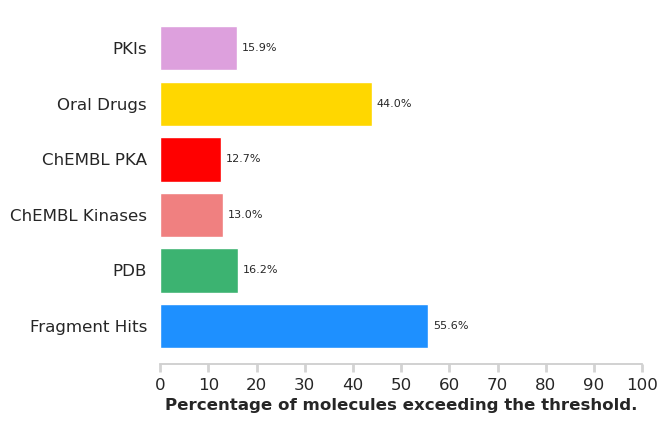

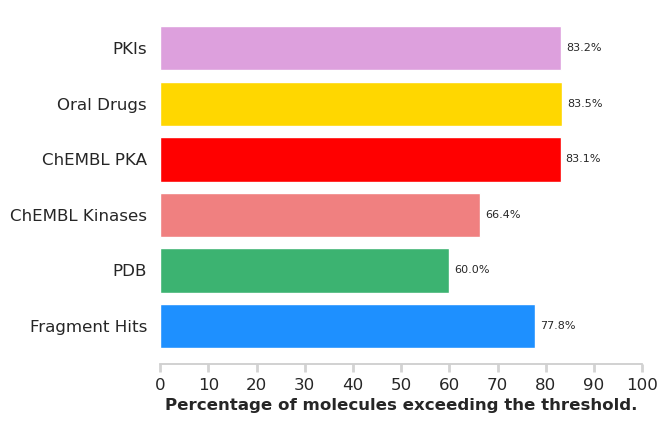

In [20]:
for descriptor in ['Fsp3_0.42', 'ΣNPR_1.07']: 
    bar_plot(percentages_df, desc = descriptor)

## NPR Triangle

In [21]:
def plot_NPR_triangle(dict_of_dfs, title=None, filepath=full_path, threshold=None):
    """
    Plot the normalized principal moments ratio plot.
    
    Parameters:
    - dict_of_dfs (dict):       A dictionary of pandas DataFrames containing the data to plot.
    - title (str, optional):    The title of the plot. Defaults to None.
    - filepath (str, optional): The filepath to save the plot to. Defaults to None.

    Returns:    None
    """

    # Create a figure and axis object
    fig, ax = plt.subplots() # figsize=(5, 4)
    plt.tight_layout()

    # First reverse the order of the key-value pairs in the dict_of_dfs, 
    # as this affects the order of plotting (datasets plotted later on may overlay the datapoints of datasets plotted earlier!)
    dict_of_dfs_reverted = dict(reversed(list(dict_of_dfs.items())))

    # Iterate over the dictionary and create a scatter plot for each
    for key, df in dict_of_dfs_reverted.items():

        # Get the color for the current DataFrame, defaults to 'lightgray' if not specified
        color = color_map.get(key, 'lightgray')
        # Get the marker for the current DataFrame, default to 'o' if not specified
        marker = marker_map.get(key, 'o')
        # Create a scatter plot with the NPR1 and NPR2 values from the DataFrame
        ax.scatter(data=df, x='NPR1', y='NPR2', label=key, color=color, marker=marker, s=7)

    # Plot the triangle lines
    x1, y1 = [0.5, 0], [0.5, 1]
    x2, y2 = [0.5, 1], [0.5, 1]
    x3, y3 = [0, 1], [1, 1]
    plt.plot(x1, y1, x2, y2, x3, y3, c='lightgray', ls='-', lw=2)
    # Add text labels for the shapes
    plt.text(0, 1.02,   s='Rod',    fontsize=12, horizontalalignment='center', verticalalignment='center', c='gray')
    plt.text(1, 1.02,   s='Sphere', fontsize=12, horizontalalignment='center', verticalalignment='center', c='gray')
    plt.text(0.5, 0.48, s='Disc',   fontsize=12, horizontalalignment='center', verticalalignment='center', c='gray')

    # Add a line for the threshold
    
    if threshold == 1.07:   # as suggested by Firth et al 
        plt.plot([0.07, 0.535], [1, 0.535],  c='lightgray', ls='--', lw=2)
    if threshold == 1.2:   # as suggested by Morrison et al 
        plt.plot([0.2, 0.6], [1, 0.6], c='lightgray', ls='--', lw=2)

    # Remove the frame and grid
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(False)

    # Adjust the axes, ticks and labels
    plt.ylim(0.45, 1.05)
    plt.xlabel('NPR1', fontsize=12, fontweight='bold')
    plt.ylabel('NPR2', fontsize=12, fontweight='bold')
    plt.tick_params('both', width=2, labelsize=12, bottom=True, left=True, color='lightgray')
    plt.xticks(np.arange(0, 1.05, 0.1))  
    plt.yticks(np.arange(0.5, 1.05, 0.1))  
    
    # Show the legend
    ax.legend(loc='center right', fontsize=12, bbox_to_anchor=(1.5, 0.71))

    # Add a title if provided
    if title: 
        plt.title(f'{title}', fontsize=12)

    # Save the plot to a file if a filename is provided
    if filepath: 
        plt.savefig(os.path.join(filepath, f"NPRTriangle_Threshold{threshold}.png"), 
                    bbox_inches='tight', dpi=1200, transparent=True)
        
    # Show the plot
    plt.show()

    # Display the plot
    plt.show()

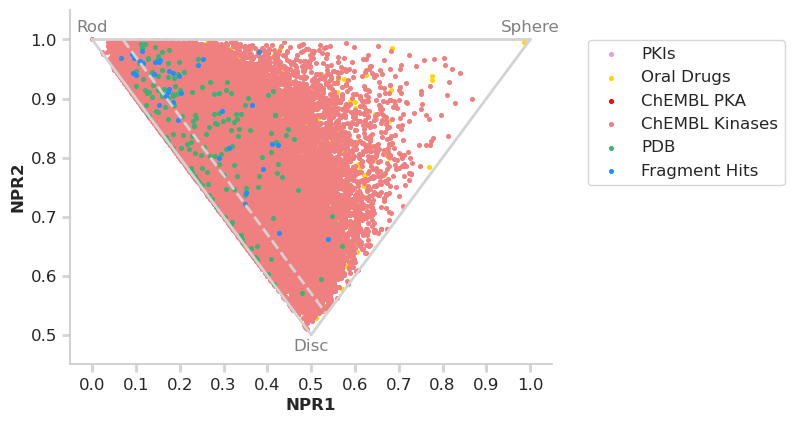

In [22]:
plot_NPR_triangle(dict_of_dfs, threshold=1.07)

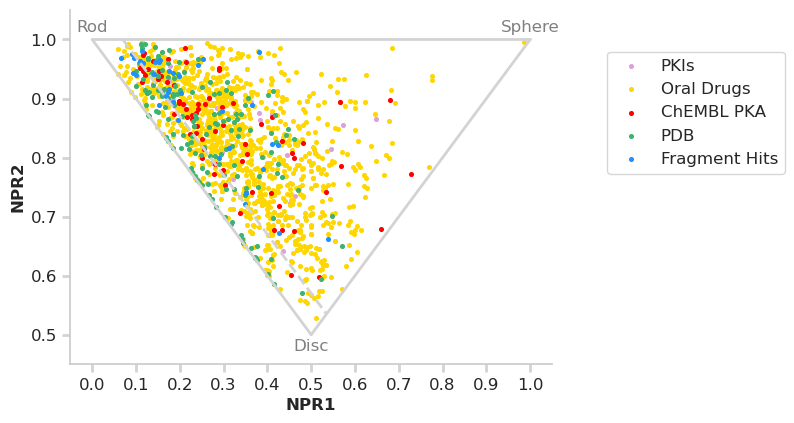

In [23]:
plot_NPR_triangle(subset_for_plotting(dict_of_dfs, ['Fragment Hits', 'PDB', 'ChEMBL PKA', 'Oral Drugs', 'PKIs']),
                  filepath=None,
                  threshold=1.07)

## Plot Distributions of Molecular Descriptors

### Raincloud and swarm plots function

In [24]:
def raincloud_and_swarm_plots(dict_of_dfs, desc, 
                    x_axis_params = x_axis_params,  
                    title=None, filepath=full_path, 
                    threshold=threshold, p_values=None):
    
    """
    Plot distributions of molecular descriptors as raincloud plots, or swarm plots (if less 100 data points)
    
    Parameters:
    - dict_of_dfs (dict):                         A dictionary of pandas DataFrames containing the data to plot.
    - desc (str):                                 The name of the molecular descriptor to be plotted.
    - x_axis_params (dict of dicts, optional):    Key = Desc. Values = Dict for the minimum, maximum and increment of the x-axis.
    - title (str, optional):                      The title of the plot. Defaults to None.
    - filepath (str, optional):                   The path to save the plot to. Defaults to None.
    - threshold (float):                          A threshold value to be visualized as vertical line in the plot.
    - p_values (DataFrame, optional): p-values with 'Dataset' and 'p-value' columns.
    """

    # Extract p-values (obtained from the Dunn statistical test) if available    
    p_value_dict = None
    if p_values is not None: 
        p_values_df = p_values[[desc]]
        p_values_df.columns = p_values_df.loc['Dataset']
        p_values_df = p_values_df.drop(['Dataset', 'Significance']).T.reset_index()
        p_value_dict = p_values_df.set_index('Dataset')['p-value'].to_dict()
        spacer = 2
    else: 
        spacer = 0.5

    # Create a figure and axis object
    plt.tight_layout() 
    fig, axs = plt.subplots(len(dict_of_dfs), 1, figsize=(7, 1*len(dict_of_dfs)))
    fig.subplots_adjust(hspace=0) # No whitespace between subplots 
    
    # Iterate over the dictionary and create a scatter plot for each
    for i, (key, df) in enumerate(dict_of_dfs.items()):

        # Get the color for the current DataFrame, defaults to 'lightgray' if not specified
        color = color_map.get(key, 'lightgray')

        # Add a vertical line at the threshold value
        if threshold and threshold[desc] != None:
            axs[i].axvline(x=threshold[desc], color='lightgray', linestyle='--', linewidth=2, zorder=0)
            thresholdstring = f"_Threshold{threshold[desc]}"
        else: 
            thresholdstring = ''

        # Usage of boxplots and density plots is only recommended for dataset sizes >= 100! 

        # Raincloud plots for large datasets
        if len(df) >= 100: 

            pt.RainCloud(data      = df, 
                        y          = desc, 
                        palette    = [color], 
                        alpha      = 0.7, 
                        ax         = axs[i], 
                        orient     = "h",
                        width_box  = 0.2,       # width of the boxplot 
                        width_viol = 0.5,       # width of the cloud
                        move       = 0.28,      # rain position (default value = 0.); e.g. move rain below box plot 0.2
                        # offset     = 0,       # cloud position to the x-axis
                        # bw = 0.2,             # cloud smoothness (default = 0.2)
                        box_showfliers = False, # do not show the flier points ('outliers') in the box plot
                        rain_zorder    = 0,     # rain in the background
                        ) 

        # But swarm plots for small datasets
        else: 

            sns.swarmplot(  data   = df, 
                            x      = desc, 
                            color  = color, 
                            alpha  = 1, 
                            ax     = axs[i], 
                            orient = "h",
                            zorder = 0 ,       
                            size   = 3,          
                            )
            
            # Visualize the median, as a short black vertical line in the swarm plot
            axs[i].axvline(x=np.nanmedian(df[desc]), color='black', linestyle='-', linewidth=1, zorder=0, ymin=0.4, ymax=0.6)

        # Adjust the axes, ticks and labels 
        axs[i].set_ylabel(key, rotation=0, horizontalalignment='right', verticalalignment='center', fontsize=12, fontweight='bold') 
        x_max = x_axis_params[desc]['x_max']
        x_min = x_axis_params[desc]['x_min']
        x_inc = x_axis_params[desc]['x_inc']
        axs[i].set_xlim(x_min - 0.5 * x_inc, x_max + spacer * x_inc)
        axs[i].set_xticks(np.arange(x_min, x_max + x_inc, x_inc))
        axs[i].grid(axis='y', visible=False)  
        axs[i].grid(axis='x', visible=True, linestyle='dotted')
        axs[i].spines[['top', 'right', 'left']].set_visible(False)  

        # Add p-value annotation to the graph if available
        if p_value_dict and key in p_value_dict:
            p_text = p_value_dict[key]
            axs[i].text(x_max + 1.2 * x_inc, 0, f"p={p_text}", va='center', ha='left', fontsize=10, color='gray')
        else: 
            axs[i].text(x_max + 1.2 * x_inc, 0, '', va='center', ha='left', fontsize=10, color='gray')

        # For all subplots, except the last one 
        # Hide the bottom spine; reset the x-axis and the x-tick labels 
        if i != len(dict_of_dfs) - 1:  
            axs[i].spines['bottom'].set_visible(False) 
            axs[i].set_xlabel('') 
            axs[i].set_xticklabels([], fontsize=0)      

    # Adjust the axes, ticks and labels for the subplot on the bottom
    axs[-1].set_xlabel(desc, fontsize=12, fontweight='bold')  
    plt.tick_params('both', width=2, labelsize=12, bottom=True, color='lightgray')

    # Add a title if provided
    if title: 
        axs[0].set_title(title, fontsize=12, ha='center')

    if filepath:
        plt.savefig(os.path.join(filepath, f"Raincloudswarmplot_{desc}{thresholdstring}.png"), 
                    dpi=1200, bbox_inches="tight", transparent=True)

    # Show the plot
    plt.show()
    

### The actual plotting of the distributions

<Figure size 640x480 with 0 Axes>

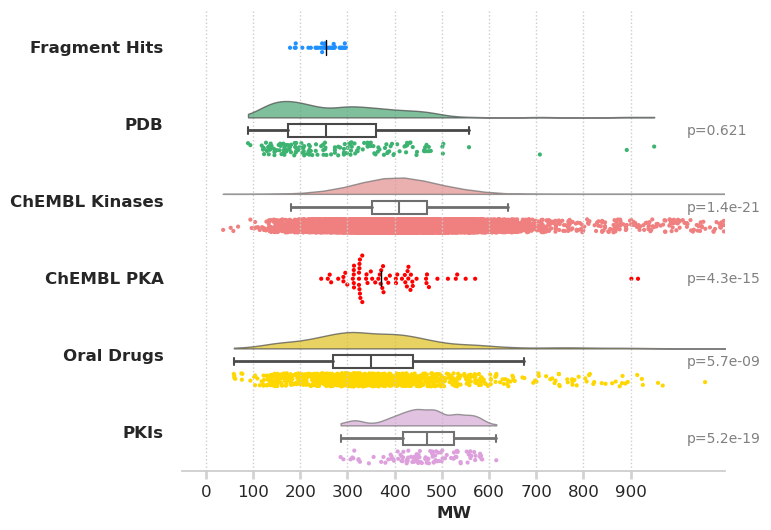

<Figure size 640x480 with 0 Axes>

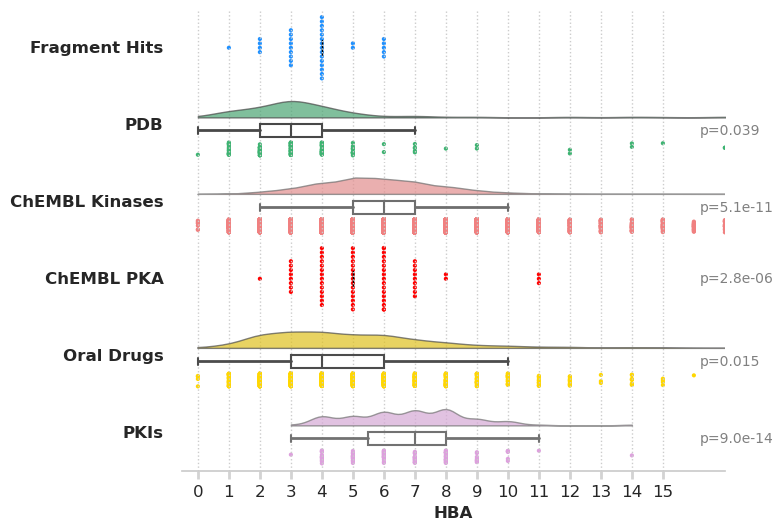

<Figure size 640x480 with 0 Axes>

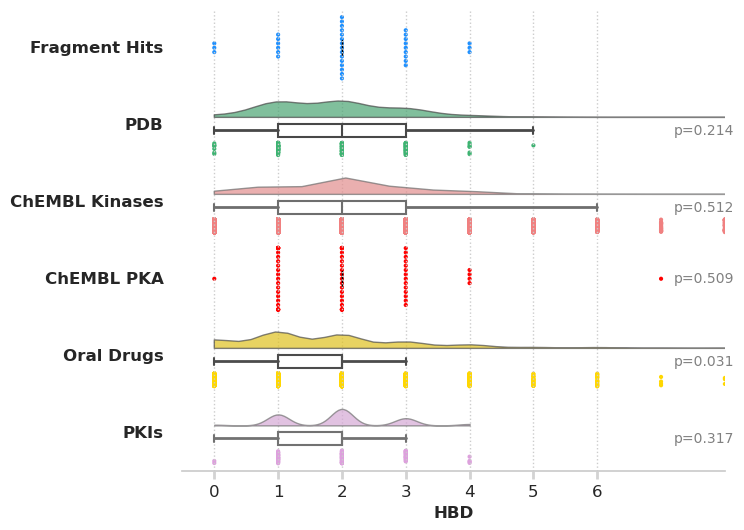

<Figure size 640x480 with 0 Axes>

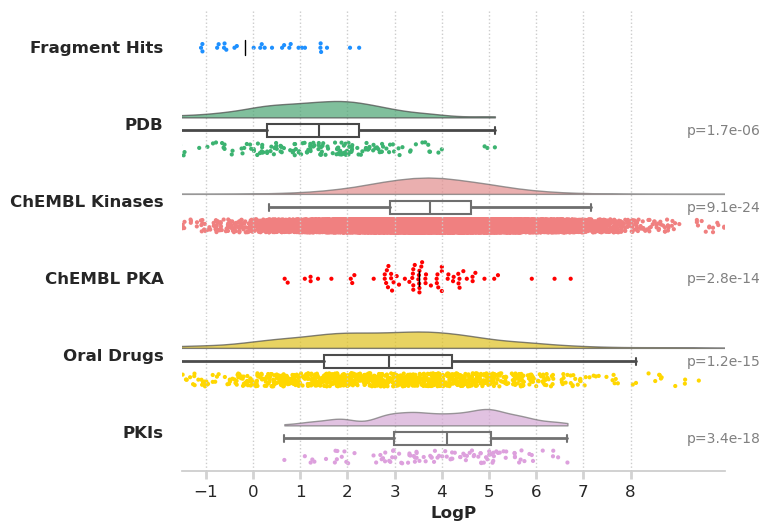

<Figure size 640x480 with 0 Axes>

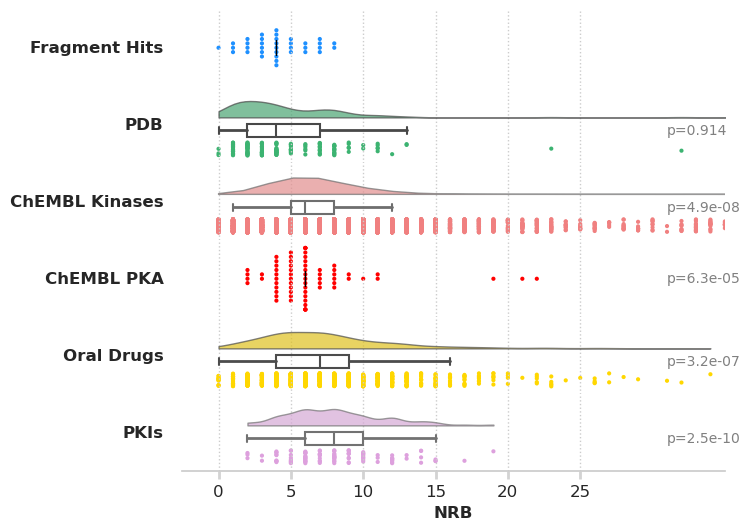

<Figure size 640x480 with 0 Axes>

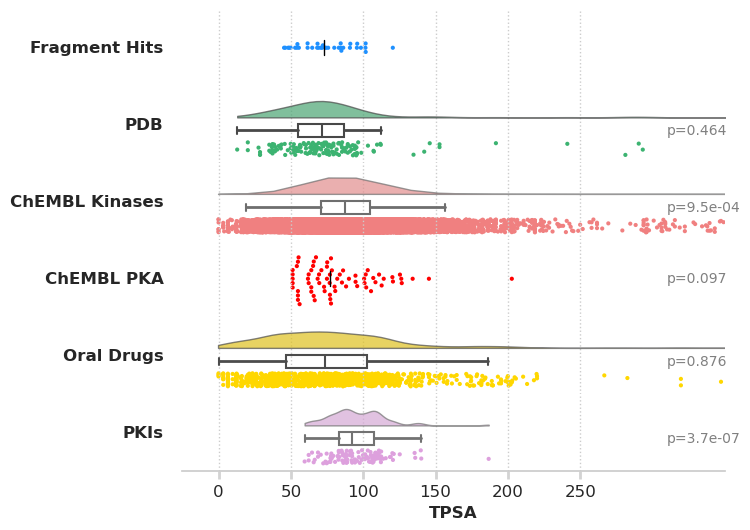

<Figure size 640x480 with 0 Axes>

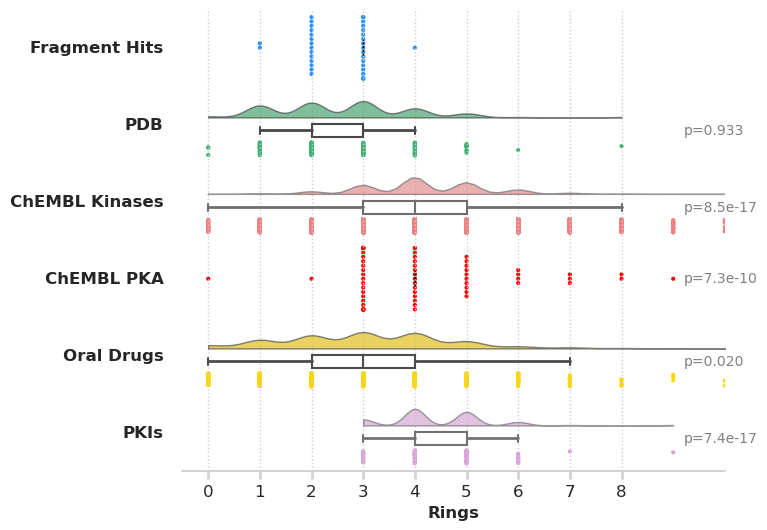

<Figure size 640x480 with 0 Axes>

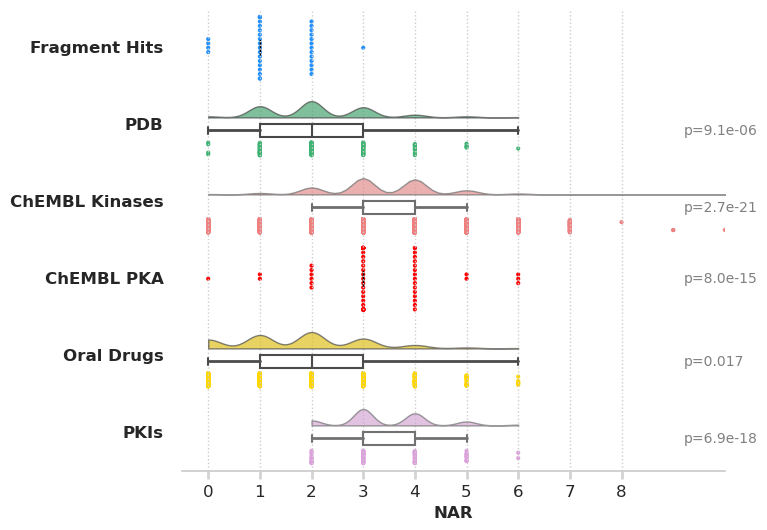

<Figure size 640x480 with 0 Axes>

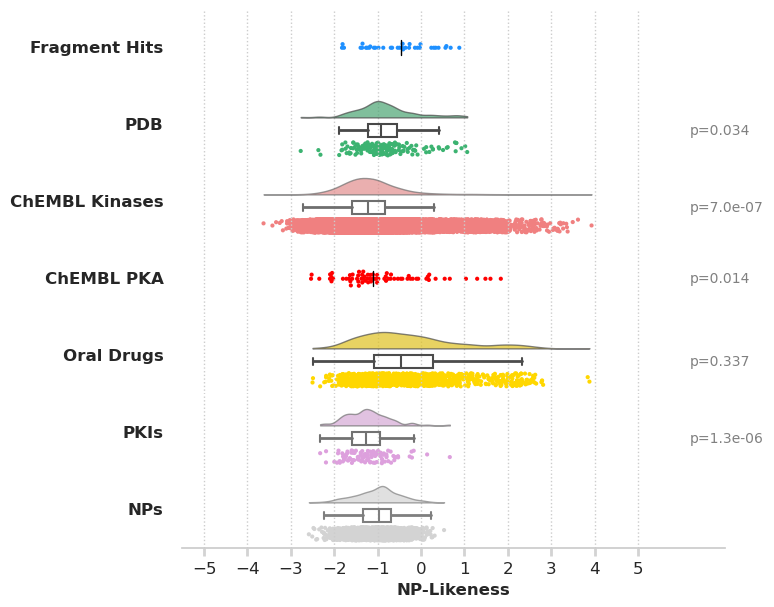

<Figure size 640x480 with 0 Axes>

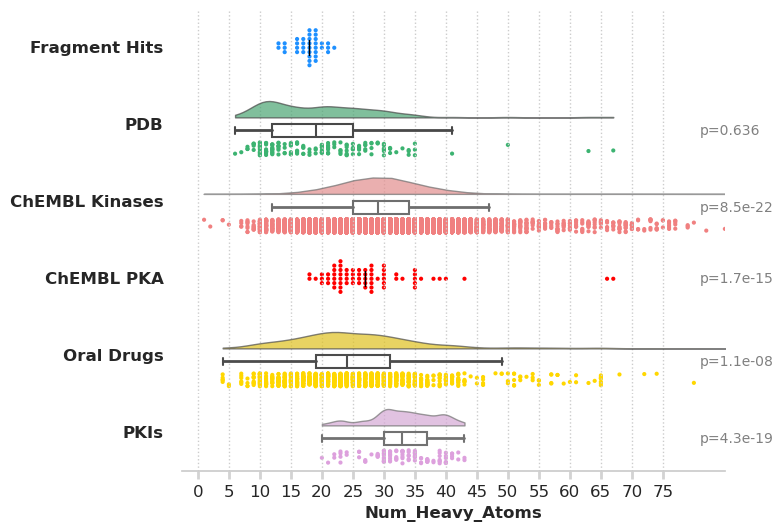

<Figure size 640x480 with 0 Axes>

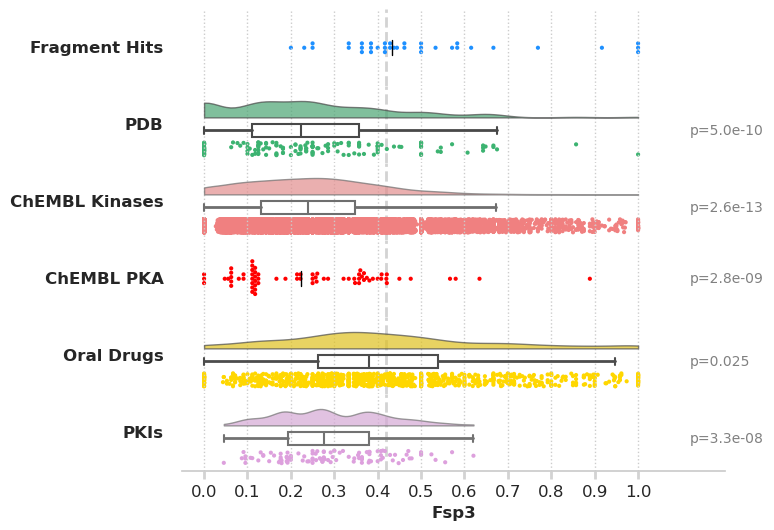

<Figure size 640x480 with 0 Axes>

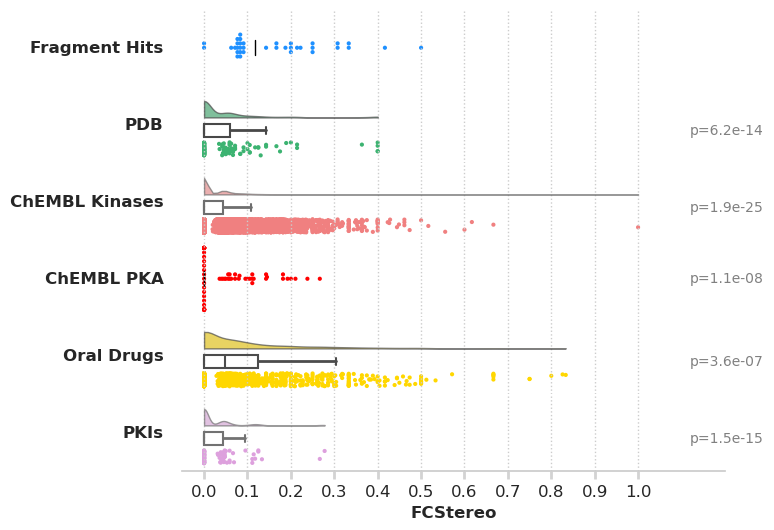

<Figure size 640x480 with 0 Axes>

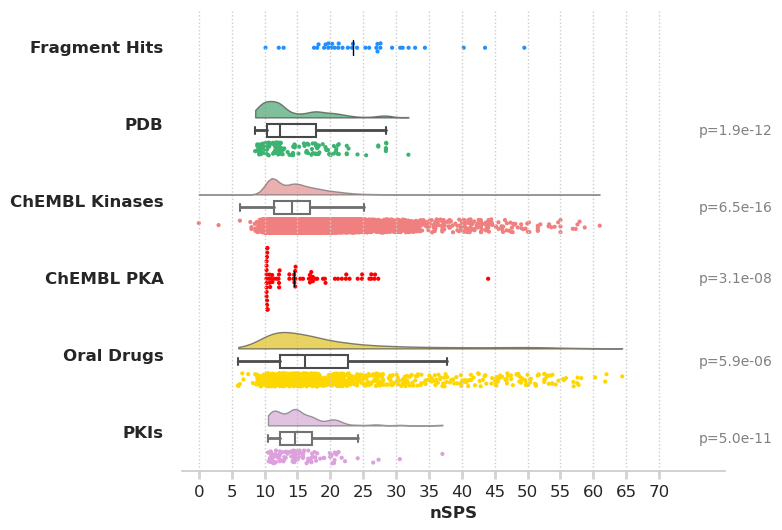

<Figure size 640x480 with 0 Axes>

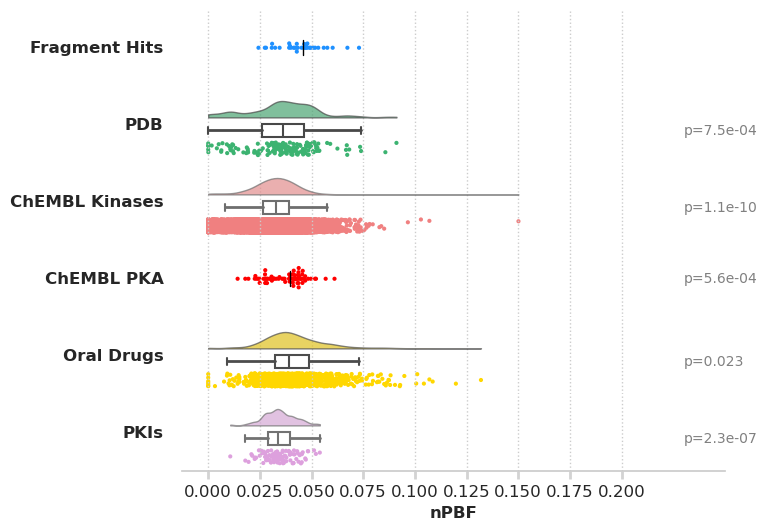

<Figure size 640x480 with 0 Axes>

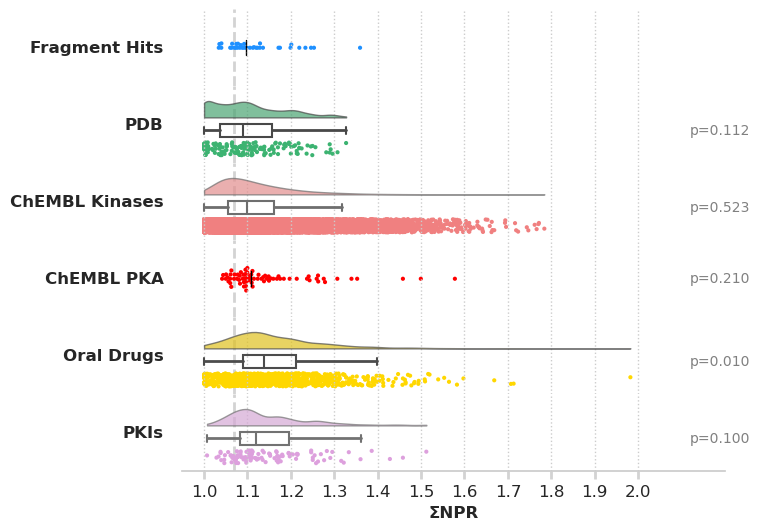

In [25]:
for descriptor in descriptors:
    if descriptor != 'NP-Likeness': 
        raincloud_and_swarm_plots(dict_of_dfs, desc=descriptor, p_values = dunn_test_results)
    else: 
        raincloud_and_swarm_plots({**dict_of_dfs, 'NPs' : NP_df}, desc='NP-Likeness', p_values = dunn_test_results)

## Radar Plots

In [26]:
def radar_scaler(df, radar_scaler_dict, threshold_scaler):
    """
    Helper function to scale the values, i.e. "prepare" the y-values for the radar plot, so that the axis can be uniform.

    Parameters
    ----------
    df (pd.DataFrame):               Dataframe with statistical measures (columns) for each physicochemical property (rows).
    radar_scaler_dict (dict of int): Contains the thresholds defined for each property.
    threshold_scaler  (numeric):     Scaled thresholds across all properties.

    Returns
    df_scales (pd.DataFrame):        DataFrame with scaled statistical measures for each physicochemical property.
    """
    for property_name in df.columns:
        # Check if threshold value is defined for the property in the radar_scaler_dict
        if property_name not in radar_scaler_dict.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
        # Scale property data by 
        # 1. Dividing each value in the dataframe by the corresponding value in the radar_scaler_dict
        # 2. Multiplying by the threshold_scaler variable 
        df_scaled = df.div(df.columns.map(radar_scaler_dict)).multiply(threshold_scaler)

    return df_scaled

In [27]:
def plot_radar(
    data,
    thresholds,
    threshold_scaler,
    # optional parameters
    rotation = None, 
    Ro5 = None, 
    Ro3 = None, 
    filename = None,
    
):
    """
    Plot a radar chart based on statistical measures of descriptor properties for multiple different datasets.

    Parameters
    ----------
    data : pd.DataFrame
        Dataframe with statistical measures of multiple descriptors (columns) for multiple datasets (rows) with the dataset name as index.
    thresholds : dict of str: int
        Thresholds defined for each property.
    threshold_scaler : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.

        
    Optional Parameters 
    -----------
    Ro5: None or "Ro5"
        Display the Lipinski Rule of Five Area.
    Ro3: None or "Ro3"
        Display the Lipinski Rule of Three Area.
    filename : None or pathlib.Path
        If not None, save plot to file.
    
    """
    ## Set figure and subplot axis 
    plt.figure(figsize=(6, 6))
    # "111" specifies the layout of the subplot in the grid. In this case, it creates a single subplot that occupies the entire grid.
    # "polar=True" sets the subplot to polar coordinates instead of the default Cartesian coordinates.
    ax = plt.subplot(111, polar=True)
    ax2 = ax.twiny

    ## Define the angles (radians) for radial (x-)axes depending on the number of descriptor values to be plotted
    # For every integer i in range i to the number of columns in data, compute the angle according to angle = i * (2π / number of columns in data)
    num_axes = data.shape[1]
    angles = [i / float(num_axes) * 2 * np.pi for i in range(num_axes)]
    # Append the first element of angles to itself    
    angles += angles[:1]

    # For rotating labels
    if rotation == None: 
        rotation = [0] * num_axes

    # Labels 
    property_labels = []
    for i in data.columns: 
        factor = round(thresholds.get(i) / threshold_scaler, 2)

        if factor == 1: 
            property_labels.append(i)

        elif factor >= 1: 
            # Check if factor can be converted to an integer, i.e. is a whole number
            try:
                int_factor = int(factor)
                if int_factor == factor:  
                    factor_str = str(int_factor)
                else:
                    raise ValueError  
            # Use fraction representation if it cannot be converted to an integer, i.e. if it's not a whole number
            except ValueError:
                factor_str     = str(thresholds.get(i))+"/"+str(threshold_scaler)
            property_labels.append(i + '\n/ ' + factor_str)
        
        else: # elif factor <= 1:
            # Check if factor can be converted to an integer, i.e. is a whole number
            try:
                inv_int_factor = int(1/factor)
                if inv_int_factor == 1/factor: 
                    factor_str_inv = str(inv_int_factor)
                else: 
                    raise ValueError
            # Use fraction representation if it cannot be converted to an integer, i.e. if it's not a whole number
            except ValueError:
                if thresholds.get(i) != 1: 
                    factor_str_inv = str(threshold_scaler)+"/"+str(thresholds.get(i))
                else: 
                    factor_str_inv = str(threshold_scaler)
            property_labels.append(i + '\n* ' + factor_str_inv)
            

    ## Scale y-axis data with respect to a defined threshold -- uses our helper function!
    scaled_data = radar_scaler(data, thresholds, threshold_scaler)
    # Since our chart will be circular, we append the first column once again to the data frame
    scaled_data = pd.concat([scaled_data, pd.DataFrame(scaled_data.iloc[:, 0])], axis=1)

    ## Maximal value 
    # Set the variable as the highest value in the scaled dataframe, rounded up to the next integer
    # The first max() method is applied to each column, 
    # and the second max() method is applied to the results of the first max() method to get the maximum value in the dataframe. 
    values_max = math.ceil(scaled_data.max().max())

    ## Save the names of the datasets in the data df (comprised in the index) to list
    dataset_list = data.index.tolist()

    # Initialize lists
    legend_labels = []
    colors = []

    ## Add the plots for the individual datasets listed in the datasets_list
    for i, dataset in enumerate(dataset_list):

        # Excluding the "Ro5" and "Ro3" criteria, as we plot them in a different manner and only optionally
        if dataset not in ["Ro5", "Ro3"]:

            # Populate the legend_labels with the dataset name 
            legend_labels.append(dataset)
            # Populate the colors list with the dataset-associated color from the color_map
            colors.append(color_map.get(dataset)) 

            actual_values = data.loc[dataset].values.tolist()
            scaled_values = scaled_data.loc[dataset].values.tolist()

            # Add the actual values as text labels to the plot
            # for angle, scaled_value, actual_value, rot in zip(angles, scaled_values, actual_values, rotation):
            #     ax.text(x = angle, 
            #             y = scaled_value, 
            #             s = int(actual_value), 
            #             size='8', color=colors[i], rotation=rot)

            ## The actual plotting
            # z-order parameter: Determines the line chart's layer in the plot. Higher values are plotted on top of lower values.
            # i % len(colors):   Choose color from the colors list based on the current i
            ax.plot(angles, 
                    scaled_values, # Add the values from the row with the dataset name as index to list
                    linewidth=1.5, linestyle='solid', zorder=1+i, color=colors[i])
            

    ## Optionally plot Ro5 / Ro3 area (if the Ro5 / Ro3 parameter is given)
    if Ro5:
        legend_labels.append("Ro5")
        ax.fill(angles, scaled_data.loc['Ro5'].values.tolist(), "gainsboro", alpha=0.5) 

    if Ro3:
        legend_labels.append("Ro3") 
        ax.fill(angles, scaled_data.loc['Ro3'].values.tolist(), "silver", alpha=0.5) 

    ## Set the orientation of the radar plot axes and the positions of the radial labels 
    # First axis on top, i.e. set 0° to 12 o'clock by rotating the theta axis counterclockwise by an angle of π/2 (90 degrees) radians.
    ax.set_theta_offset(np.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)
    # Set the radial label position to an angle of 0 radians
    ax.set_rlabel_position(0)
    # Customize the y-labels, ranging from 0 to the values_max +1
    ax.set_rgrids(range(0, values_max+1, 1), color="black", size=7)

    # Reset the x-tick labels 
    plt.xticks(angles, [])

    # Set the title of the plot
    # Adjust the placement of the radial (x-)axes' labels
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    # Iterate over the angles and properties_labels in the eponymous lists
    for i, (angle, label, rotation) in enumerate(zip(angles[:-1], property_labels, rotation)):

        # Add a text annotation to the plot at the current angle position 
        # x and y parameters specify the coordinates of the text annotation, being the angle and the values_max+2 ring 
        # The s parameter specifies the text label.
        ax.text(
            x=angle,
            y=values_max+1.5,
            s=label,
            size=12,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=rotation,
        )

    ## Add a legend to the top-right corner of the plot
    ax.legend(legend_labels, labelspacing=0.3, fontsize=10, loc='center right', bbox_to_anchor=(1.5, 0.5))

    # Save plot, if a filename is given
    if filename:
        plt.savefig(os.path.join(full_path, filename), dpi=1200, bbox_inches="tight", transparent=True)

    plt.show()

In [28]:
def select_data_for_radar_plot(df, cols): 
    df['(2 + NP-Likeness)'] = 2 + df['NP-Likeness']

    # Data subset 
    radar_df = df[cols] 

    # Rule-of-Five and the Rule-of-Three criteria 
    Ro5 = pd.DataFrame([{'Dataset': 'Ro5', 'MW':500, 'HBA':10, 'HBD':5, 'LogP':5, 'NRB':10, 'TPSA':140, 'NAR':3
                         }]).set_index('Dataset')
    Ro3 = pd.DataFrame([{'Dataset': 'Ro3', 'MW':300, 'HBA': 3, 'HBD':3, 'LogP':3, 'NRB': 0, 'TPSA':  0, 'NAR':0
                         }]).set_index('Dataset')

    # Append Ro5 and Ro3 to radar_df using concat
    radar_df = pd.concat([radar_df, Ro5, Ro3])

    # Drop the NP dataset
    radar_df.drop('NPs', inplace=True)

    return radar_df

In [29]:
cols = ['MW', 'HBA', 'HBD', 'LogP', 'NRB', 'TPSA', 'NAR', '(2 + NP-Likeness)', 'Fsp3', 'FCStereo', 'nSPS', 'nPBF']
radar_df = select_data_for_radar_plot(median_df, cols)
radar_df

,MW,HBA,HBD,LogP,NRB,TPSA,NAR,(2 + NP-Likeness),Fsp3,FCStereo,nSPS,nPBF
Fragment Hits,253.814,4.0,2.0,-0.167,4.0,72.895,1.0,1.537,0.433,0.117,23.372,0.046
PDB,254.271,3.0,2.0,1.392,4.0,71.485,2.0,1.081,0.222,0.000,12.330,0.036
ChEMBL Kinases,408.542,6.0,2.0,3.740,6.0,87.140,3.0,0.770,0.240,0.000,14.154,0.033
ChEMBL PKA,371.426,5.0,2.0,3.520,6.0,77.240,3.0,0.881,0.222,0.000,14.500,0.040
Oral Drugs,349.354,4.0,2.0,2.882,7.0,73.860,2.0,1.531,0.381,0.048,16.189,0.039
PKIs,467.849,7.0,2.0,4.104,8.0,92.350,3.0,0.731,0.276,0.000,14.632,0.034
Ro5,500.000,10.0,5.0,5.000,10.0,140.000,3.0,NaN,NaN,NaN,NaN,NaN
Ro3,300.000,3.0,3.0,3.000,0.0,0.000,0.0,NaN,NaN,NaN,NaN,NaN


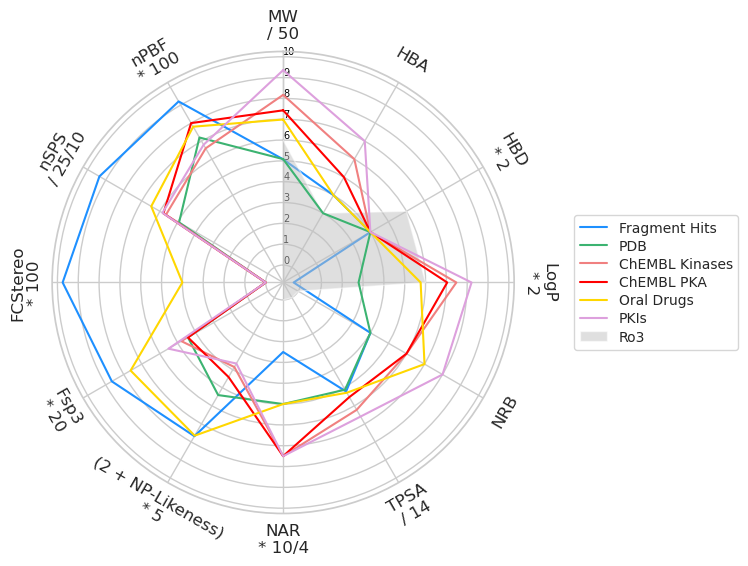

In [30]:
plot_radar(data = radar_df, 
           thresholds = {"MW": 500, "HBA": 10, "HBD": 5, "LogP": 5, "NRB": 10, 'TPSA': 140, 'Rings': 4, 'NAR': 4, '(2 + NP-Likeness)': 2, 'Fsp3': 0.5, 'FCStereo': 0.12, 'nSPS': 25, 'nPBF' : 0.05}, 
           threshold_scaler = 10, 
           rotation = [0, -30, -60, -90, +60, +30, 0, -30, -60, +90, +60, +30],
           #Ro5 = "Ro5", 
           Ro3 = "Ro3", 
           filename='Radar_Plot_All_Descriptors.png'      
           )

**Lipinski's Rule of Five (Lipinski 1997)**
- MW ≤ 500 Daltons (Da), 
- calculated logarithm of the n-octanol/water partition coefficient (clogP) < 5 units,
- number of hydrogen-bond acceptors (HBAs) ≤ 10 (roughly defined as the number of O atoms and N atoms) and 
- number of hydrogen-bond donors (HBDs) ≤ 5 (roughly defined as the number OHs and NHs). 

Extension by Veber et al. 2002:
- number of rotatable bonds (NRB) ≤ 10
- polar surface area ≤ 140 Å^2

Extension by Ghose et al. 1999: 
- number of atoms (N) ≤ 70

Extension by Ritchie and MacDonald 2009: 
- number of aromatic rings (NAR) ≤ 3 <br>
In this publication, fused rings are counted individually, but not in the RDKit implementation herein! 

**Rule of Three (Congreve et al. 2003)**
- MW ≤ 300 Da,
- clogP < 3 units,
- HBDs ≤ 3,
- HBAs ≤ 3.